In [1]:
import h5py

# Path to your HDF5 file
file_path = '/kaggle/input/treedata/gist-960-euclidean.hdf5'

# Open the HDF5 file
with h5py.File(file_path, 'r') as f:
    # List all keys in the HDF5 file
    print("Keys in the HDF5 file:", list(f.keys()))

    # Read the training set, queries, ground truth, and distances
    train_data = f['train'][:]  # Assuming 'train' is the key for training data
    query_data = f['test'][:]  # Assuming 'test' is the key for query data
    ground_truth = f['neighbors'][:]  # Assuming 'neighbors' is the key for ground truth neighbors
    distance = f['distances'][:]  # Assuming 'distances' is the key for distances

    # Display some details about the datasets
    print("Train data shape:", train_data.shape)
    print("Query data shape:", query_data.shape)
    print("Ground truth shape:", ground_truth.shape)
    print("Distance shape:", distance.shape)


Keys in the HDF5 file: ['distances', 'neighbors', 'test', 'train']
Train data shape: (1000000, 960)
Query data shape: (1000, 960)
Ground truth shape: (1000, 100)
Distance shape: (1000, 100)


In [27]:
import heapq

In [44]:
import math

class Rect:
    def __init__(self, mins, maxs):
        # `mins` and `maxs` are lists/tuples of length `m`
        self.mins = mins  # Minimum bounds for each dimension
        self.maxs = maxs  # Maximum bounds for each dimension

    def coords(self):
        return self.mins + self.maxs  # Return the min and max for all dimensions

    def area(self):
        """Calculate the area/volume of the rectangle"""
        sides = self.maxs - self.mins
        return np.prod(sides)
    
    def union(self, other):
        """Return the union of this rectangle with another"""
        mins = np.minimum(self.mins, other.mins)
        maxs = np.maximum(self.maxs, other.maxs)
        return Rect(mins, maxs)
    
    def intersect(self, other):
        """Return the intersection of this rectangle with another"""
        mins = np.maximum(self.mins, other.mins)
        maxs = np.minimum(self.maxs, other.maxs)
        # Check if intersection is valid
        if np.any(mins >= maxs):
            # Return a zero-area rectangle if there's no intersection
            return Rect(mins, mins)
        return Rect(mins, maxs)
    
    def does_intersect(self, other):
        """Check if this rectangle intersects with another"""
        intersection = self.intersect(other)
        return np.all(intersection.mins < intersection.maxs)
    
    def does_contain(self, other):
        """Check if this rectangle contains another"""
        return np.all(self.mins <= other.mins) and np.all(self.maxs >= other.maxs)
    
    def distance_to(self, point):
        """Calculate the minimum distance from the rectangle to a point"""
        point = np.array(point)
        # Find the closest point on the rectangle to the given point
        closest = np.maximum(self.mins, np.minimum(point, self.maxs))
        return np.linalg.norm(closest - point)

    def grow(self, amt):
        # Expand the rectangle by a given amount in all dimensions
        return Rect([self.mins[i] - amt for i in range(len(self.mins))],
                    [self.maxs[i] + amt for i in range(len(self.maxs))])
    def diagonal(self):
        # Calculate the diagonal length (Euclidean distance across all dimensions)
        return math.sqrt(sum((self.maxs[i] - self.mins[i]) ** 2 for i in range(len(self.mins))))
    def __str__(self):
        return f"Min: {self.mins}, Max: {self.maxs}"
    def __eq__(self,other):
        return self.mins == other.mins and self.maxs == other.maxs


# NullRect represents an empty rectangle.
NullRect = Rect([0.0, 0.0] ,[0.0, 0.0])

# Utility function to calculate the union of all rectangles in a list.
def union_all(rects):
    """Return the union of a list of rectangles."""
    if not rects:
        return NullRect

    result = rects[0]
    for rect in rects[1:]:
        result = result.union(rect)
    return result

In [31]:
class Entry:
    """
    Represents an entry in an RTreeNode. The format of the entry depends on whether the node is a leaf or not.
    """
    def __init__(self, bounding_box, value):
        """
        Initialize an entry.
        :param bounding_box: The bounding rectangle (`Rect`).
        :param value: For leaf nodes, `value` is an ID (e.g., tuple identifier).
                      For non-leaf nodes, `value` is a child node (`RTreeNode`).
        """
        self.bounding_box = bounding_box  # The bounding rectangle
        self.value = value  # Either an ID (leaf node) or a child node (non-leaf node)
        self.node=node

    def is_leaf_entry(self):
        """
        Check if this entry belongs to a leaf node.
        :return: True if the entry's value is an ID, False if it is a child node.
        """
        return not isinstance(self.value, RTreeNode)

    def __str__(self):
        """
        String representation of the entry.
        """
        entry_type = "Leaf Entry" if self.is_leaf_entry() else "Non-leaf Entry"
        return f"{entry_type}: Bounding Box={self.bounding_box.coords()}, Value={self.value}"


class RTreeNode:
    """
    Represents a node in an R-tree. Contains multiple entries, and each entry may point to child nodes.
    """
    def __init__(self, is_leaf=False, parent_entry=None):
        """
        Initialize an RTreeNode.
        :param is_leaf: Boolean indicating if this is a leaf node.
        :param parent_entry: The entry pointing to this node (None for the root node).
        """
        self.is_leaf = is_leaf  # True if the node is a leaf, False otherwise
        self.entries = []       # List of Entry objects
        self.parent_entry = parent_entry  # Reference to the parent entry (None for the root node)

    def add_entry(self, bounding_box, value):
        """
        Add an entry to the node.
        :param bounding_box: The bounding rectangle (`Rect`).
        :param value: If this is a leaf node, `value` is a tuple identifier (e.g., an ID).
                      If this is a non-leaf node, `value` is a child node (`RTreeNode`).
        """
        entry = Entry(bounding_box, value)  # Create an entry

        self.entries.append(entry)
        entry.node=self

        # If the value is a child node, update its parent entry to this entry
        if isinstance(value, RTreeNode):
            value.parent_entry = entry

    def __str__(self):
        """
        String representation of the node.
        """
        node_type = "Leaf" if self.is_leaf else "Non-leaf"
        return f"{node_type} Node: {len(self.entries)} entries"
    def rect(self):
        return union_all([e.bounding_box for e in self.entries])
def union_all_leaf(rects):
    """
    Return the union of rectangles for leaf nodes, extending dimensions when points align.
    """
    """Return the union of a list of rectangles."""
    if not rects:
        return NullRect

    result = rects[0]
    for rect in rects[1:]:
        result = result.union(rect)
    for i in range(len(result.mins)):
        if result.mins[i] == result.maxs[i]:
            result.maxs[i] =result.maxs[i]+0.2
    return result

def leaf(objet):
    if isinstance(objet, RTreeNode):
        return objet.is_leaf
    else:
        return objet.is_leaf_entry()

In [49]:

class RTree:
    def __init__(self, max_entries=4, min_entries=2):
        self.max_entries = max_entries  # Max entries before a split
        self.min_entries = min_entries  # Min entries after a split
        self.root = RTreeNode(is_leaf=True)  # Initialize the root as a leaf node

    def insert(self, bounding_box, value):
        """
        Insert a new entry into the R-tree.
        :param bounding_box: The bounding rectangle for the entry.
        :param value: The value associated with the entry (ID for leaf or child node for non-leaf).
        """
        rect = Rect(bounding_box[0], bounding_box[1])
        leaf = self.choose_leaf(self.root, rect)  # Step 1: Find the appropriate leaf nod
        # Step 2: Insert the new entry into the leaf node
        leaf.add_entry(rect, value)

        # Step 3: Handle node overflow
        if len(leaf.entries) > self.max_entries:
            self.split_and_propagate(leaf)
        self.adjust_tree(leaf)

    def adjust_tree(self, node):
        """
        Adjust the tree by propagating changes upward, updating bounding boxes and handling splits.
        :param node: The node that was modified (usually the leaf node).
        """
        current_node = node
        while current_node is not None:
            # If the node is the root, stop the adjustment process
            if current_node is self.root:
                break

            # Step 1: Get the parent node and the entry pointing to the current node
            parent_entry = current_node.parent_entry # parent entry
            node_entry = parent_entry.node


            # Step 2: Adjust the bounding box of the parent entry to enclose all rectangles in current node

            parent_entry.bounding_box = union_all_leaf([e.bounding_box for e in current_node.entries])

            # Step 3: If the parent node exceeds max entries, we need to split it
            if len(node_entry.entries) > self.max_entries:
                self.split_and_propagate(node_entry)

            # Move up to the parent node for the next iteration
            current_node = node_entry

    def choose_leaf(self, node, rect):
        """
        Find the appropriate leaf node for a new entry.
        :param node: The current node to search.
        :param rect: The bounding rectangle of the new entry.
        :return: The leaf node where the entry should be inserted.
        """
        if node.is_leaf:

            return node

        # Choose the entry that requires the least enlargement of its bounding box
        best_entry = min(
            node.entries,
            key=lambda e: e.bounding_box.union(rect).area() - e.bounding_box.area()
        )
        return self.choose_leaf(best_entry.value, rect)  # Recurse into the child node

    def split_and_propagate(self, node):
        """
        Handle node splitting and propagate changes upwards.
        :param node: The node to split.
        """
        new_node, new_entry = self.split_node(node)

        # If the node is the root, create a new root
        if node is self.root:
            new_root = RTreeNode(is_leaf=False)
            new_root.add_entry(union_all([e.bounding_box for e in node.entries]), node)
            new_root.add_entry(union_all([e.bounding_box for e in new_node.entries]), new_node)
            self.root = new_root
        else:
            # Add the new entry to the parent node

            parent = node.parent_entry
            node_entry = parent.node
            node_entry.add_entry(new_entry.bounding_box, new_entry.value)

            # Propagate split if the parent overflows
            if len(node_entry.entries) > self.max_entries:
                self.split_and_propagate( node_entry)

    def split_node(self, node):
        """
        Split a node into two nodes using the quadratic split algorithm.
        :param node: The node to split.
        :return: A tuple (new_node, new_entry) where new_node is the split-off node and
                new_entry is the entry to be added to the parent.
        """
        entries = node.entries[:]
        group1, group2 = self.quadratic_split(entries)

        # Create a new node for group2 with the same type as the original node
        new_node = RTreeNode(is_leaf=node.is_leaf)
        for entry in group2:
            new_node.add_entry(entry.bounding_box, entry.value)

        # Update the original node with group1
        node.entries = group1

        # Create a new entry for the split-off node

        new_bounding_box = union_all([entry.bounding_box for entry in group2])
        new_entry = Entry(new_bounding_box, new_node)

        return new_node, new_entry

    def count_total_nodes(self):
        """
        Calculate the total number of nodes in the R-tree
        Returns: (total_nodes, leaf_nodes, internal_nodes)
        """
        def count_recursive(node):
            if node is None:
                return 0, 0, 0
                
            if node.is_leaf:
                return 1, 1, 0  # total, leaf, internal
                
            # Count this internal node
            total = 1
            leaves = 0
            internal = 1
            
            # Recursively count children
            for entry in node.entries:
                child_total, child_leaves, child_internal = count_recursive(entry.value)
                total += child_total
                leaves += child_leaves
                internal += child_internal
                
            return total, leaves, internal
        
        return count_recursive(self.root)
    def quadratic_split(self, entries):
        """
        Quadratic-cost splitting algorithm to divide entries into two groups.
        :param entries: List of entries to split.
        :return: Two groups of entries.
        """
        seed1, seed2 = self.pick_seeds(entries)
        group1 = [seed1]
        group2 = [seed2]
        entries.remove(seed1)
        entries.remove(seed2)

        while entries:
            # If one group needs all remaining entries to satisfy min_entries, assign them directly
            if len(group1) + len(entries) == self.min_entries:
                group1.extend(entries)
                break
            elif len(group2) + len(entries) == self.min_entries:
                group2.extend(entries)
                break

            # Pick the next entry to assign
            entry = self.pick_next(group1, group2, entries)
            bbox1 = union_all([e.bounding_box for e in group1])
            bbox2 = union_all([e.bounding_box for e in group2])

            # Assign to the group with least enlargement; resolve ties by size, then count
            if bbox1.union(entry.bounding_box).area() - bbox1.area() < bbox2.union(entry.bounding_box).area() - bbox2.area():
                group1.append(entry)
            else:
                group2.append(entry)

            entries.remove(entry)

        return group1, group2


    def pick_seeds(self, entries):
        """
        Choose the initial seeds for the quadratic split.
        :param entries: List of entries to split.
        :return: Two entries to initialize the groups.
        """
        max_diff = -float('inf')
        seed1 = seed2 = None
        for i in range(len(entries)):
            for j in range(i + 1, len(entries)):
                area_union = entries[i].bounding_box.union(entries[j].bounding_box).area()
                area_sum = entries[i].bounding_box.area() + entries[j].bounding_box.area()
                diff = area_union - area_sum
                if diff > max_diff:
                    max_diff = diff
                    seed1 = entries[i]
                    seed2 = entries[j]
        #print(seed1)
        #print(seed2)
        return seed1, seed2

    def pick_next(self, group1, group2, entries):
        """
        Choose the next entry to assign during a quadratic split.
        :param group1: First group of entries.
        :param group2: Second group of entries.
        :param entries: Remaining entries to assign.
        :return: The next entry to assign.
        """
        max_diff = -float('inf')
        next_entry = None
        for entry in entries:
            bbox1 = union_all([e.bounding_box for e in group1])
            bbox2 = union_all([e.bounding_box for e in group2])
            diff = abs(
                bbox1.union(entry.bounding_box).area() - bbox1.area() -
                (bbox2.union(entry.bounding_box).area() - bbox2.area())
            )
            if diff > max_diff:
                max_diff = diff
                next_entry = entry
        #print(next_entry)
        return next_entry
    def delete(self, bounding_box, value):
        """
        Remove an entry with the specified bounding box and value from the R-tree.
        :param bounding_box: The bounding rectangle of the entry to remove.
        :param value: The value associated with the entry to remove.
        """
        rect = Rect(bounding_box[0], bounding_box[1])
        target = Entry(rect,value)
        # Step D1: Find the leaf node containing the entry
        leaf = self.find(self.root, target)
        if not leaf:
            print("Entry not found.")
            return  # Entry not found

        # Step D2: Delete the record
        leaf.entries = [e for e in leaf.entries if not (e.bounding_box == rect and e.value == value)]

        # Step D3: Propagate changes
        self.condense_tree(leaf)

        # Step D4: Shorten tree if necessary
        if len(self.root.entries) == 1 and not self.root.is_leaf:
            self.root = self.root.entries[0].value

    def find_leaf(self, node, target, last_visited=None):
        """
        Find the leaf node containing the entry with the specified bounding box and value.
        :param node: The current node to search.
        :param rect: The bounding rectangle of the entry.
        :param value: The value associated with the entry.
        :param last_visited: The last visited entry at the current node to track progress during backtracking.
        :return: The leaf node containing the entry, or None if not found.
        """
        rect = target.bounding_box
        value = target.value

        if node.is_leaf:
            # FL2: Search leaf node for the record
            for entry in node.entries:
                print(entry)

                if entry.bounding_box == rect and entry.value == value:

                    return node

            # If not found, move back up and explore siblings
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)

            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        # FL1: Search subtrees
        found = False  # Track if a match is found
        for entry in node.entries:
            if last_visited is not None and entry == last_visited:
                # Skip already visited entries
                continue

            if entry.bounding_box.does_intersect(rect):
                result = self.find_leaf(entry.value, target)
                if result:  # Stop search if the entry is found
                    return result
                found = True

        # Move back up and explore siblings if not found
        if not found:
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)


            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        return None
    def find(self, node, target, last_visited=None):
        """
        Find the leaf node containing the entry with the specified bounding box and value.
        :param node: The current node to search.
        :param rect: The bounding rectangle of the entry.
        :param value: The value associated with the entry.
        :param last_visited: The last visited entry at the current node to track progress during backtracking.
        :return: The leaf node containing the entry, or None if not found.
        """
        rect = target.bounding_box
        value = target.value

        if node.is_leaf:
            # FL2: Search leaf node for the record
            for entry in node.entries:
                if entry.bounding_box == rect and entry.value == value:

                    return node

            # If not found, move back up and explore siblings
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)

            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        # FL1: Search subtrees
        found = False  # Track if a match is found
        for entry in node.entries:
            print(entry)
            if last_visited is not None and entry == last_visited:
                # Skip already visited entries
                continue

            if entry.bounding_box.does_contain(rect):
                result = self.find_leaf(entry.value, target)
                if result:  # Stop search if the entry is found
                    return result
                found = True

        # Move back up and explore siblings if not found
        if not found:
            parent_entry = node.parent_entry
            if parent_entry is None:  # Root node reached
                return self.explore_remaining_siblings(node, target, last_visited=parent_entry)


            parent_node = parent_entry.node
            return self.explore_remaining_siblings(parent_node, target, last_visited=parent_entry)

        return None

    def explore_remaining_siblings(self, parent_node, target, last_visited):
        """
        Explore remaining sibling subtrees of the current node.
        :param parent_node: The parent node whose entries are being explored.
        :param rect: The bounding rectangle of the entry.
        :param value: The value associated with the entry.
        :param last_visited: The last visited entry in the parent node.
        :return: The leaf node containing the entry, or None if not found.
        """
        last_visited_found = False

        for entry in parent_node.entries:
            if not last_visited_found:
                if entry == last_visited:
                    last_visited_found = True
                continue

            # Explore the next subtree
            result = self.find(entry.value, target)
            if result:
                return result

        # If all siblings are explored, move up again
        if parent_node.parent_entry is not None:
            return self.explore_remaining_siblings(parent_node.parent_entry.node, target, parent_node.parent_entry)

        return None




    def condense_tree(self, node):
        """
        Condense the tree after a deletion, handling underflow and re-inserting orphaned entries.
        :param node: The node from which an entry was deleted.
        """
        Q = []  # Set of eliminated nodes
        current_node = node
        parent_entry = current_node.parent_entry
        while current_node is not None:
            # If the node is underfull, remove it and add its entries to Q
            if len(current_node.entries) < self.min_entries and current_node != self.root:

                parent_node = parent_entry.node

                # Remove the entry pointing to the current node
                parent_node.entries = [e for e in parent_node.entries if e.value != current_node]

                # Add the current node's entries to Q
                Q.extend(current_node.entries)
            else:
                # Adjust the bounding box of the parent entry to tightly enclose the current node
                if current_node != self.root:
                    parent_entry.bounding_box = union_all([e.bounding_box for e in current_node.entries])

            # Move up the tree
            current_node = current_node.parent_entry.node if current_node.parent_entry else None

        # Re-insert orphaned entries
        for entry in Q:
            if isinstance(entry.value, RTreeNode):
                self.reinsert_subtree(entry)
            else:
                self.insert((entry.bounding_box.mins,entry.bounding_box.maxs), entry.value)

    def reinsert_subtree(self, entry):
        """
        Reinsert a subtree entry into the R-tree at the appropriate level.
        :param entry: The entry to reinsert.
        """
        node = self.choose_subtree(self.root, entry.bounding_box)
        node.add_entry(entry.bounding_box, entry.value)

        # Handle overflow if necessary
        if len(node.entries) > self.max_entries:
            self.split_and_propagate(node)
    def search(self, entry,value):
        """
        Search the R-tree for all entries whose rectangles overlap the given search rectangle.
        :param search_rect: The search rectangle (instance of Rect).
        :return: A list of qualifying entries.
        """
        rect = Rect(entry, entry)
        target = Entry(rect,value)
        # Step D1: Find the leaf node containing the entry
        leaf = self.find(self.root, target)
        if not leaf:
            print("Entry not found.")
            return  # Entry not found
        else:
            print('True')
    def range_search(self, search_rect):
        """
        Search the R-tree for all entries whose rectangles overlap the given search rectangle.
        :param search_rect: The search rectangle (instance of Rect).
        :return: List of qualifying entries.
        """
        results = []
        self._search_node(self.root, search_rect, results)
        return results

    def _search_node(self, node, search_rect, results):
        """
        Recursively search the R-tree nodes for overlapping rectangles.
        :param node: Current node being searched
        :param search_rect: Search rectangle
        :param results: List to accumulate qualifying entries
        """
        if node.is_leaf:
            # Search leaf node
            for entry in node.entries:
                if search_rect.does_contain(entry.bounding_box):
                    results.append(entry)
        else:
            # Search subtrees
            for entry in node.entries:
                if entry.bounding_box.does_intersect(search_rect):
                    self._search_node(entry.value, search_rect, results)

    def nearest_neighbor(self, query_point):
        """
        Find the nearest neighbor to the query point.
        :param query_point: Tuple (x, y) representing query point
        :return: Tuple (distance, value) of nearest neighbor
        """
        return self._nearest_neighbor_recursive(self.root, query_point)

    def _nearest_neighbor_recursive(self, node, query_point, best=None):
        if node.is_leaf:
            for entry in node.entries:
                #print(entry.bounding_box)
                #print(entry.bounding_box.type)
                dist = entry.bounding_box.distance_to(query_point)
                coords = entry.bounding_box.mins
                if best is None or dist < best[0]:
                    best = (dist, coords, entry.value)
        else:
            priority_queue = []
            for entry in node.entries:
                #print(entry.bounding_box)
                #print(entry.bounding_box.type)
                dist = entry.bounding_box.distance_to(query_point)
                if best is None or dist < best[0]:
                    heapq.heappush(priority_queue, (dist, entry.value))

            while priority_queue:
                _, child = heapq.heappop(priority_queue)
                best = self._nearest_neighbor_recursive(child, query_point, best)

        return best

    def knn(self, query_point, k):
        """
        Optimized k-nearest neighbors search for R-tree.
        """
        best = []  # Max-heap to track best k neighbors
        current_best_k = float('inf')  # Distance to the farthest neighbor in best list

        # Ensure query point is in tuple format
        if not isinstance(query_point, tuple):
            query_point = tuple(query_point.tolist()) if hasattr(query_point, 'tolist') else tuple(query_point)

        def knn_recursive(node, depth=0):
            nonlocal current_best_k

            if node.is_leaf:
                # Batch process leaf entries
                distances_and_entries = []
                for entry in node.entries:
                    dist = entry.bounding_box.distance_to(query_point)
                    coords = tuple(entry.bounding_box.mins.tolist()) if hasattr(entry.bounding_box.mins, 'tolist') else tuple(entry.bounding_box.mins)
                    value = tuple(entry.value.tolist()) if hasattr(entry.value, 'tolist') else tuple(entry.value)
                    distances_and_entries.append((dist, coords, value))

                # Sort entries by distance for efficient processing
                for dist, coords, value in sorted(distances_and_entries, key=lambda x: x[0]):
                    if len(best) < k:
                        heapq.heappush(best, (-dist, coords, value))
                        if len(best) == k:
                            current_best_k = -best[0][0]
                    elif dist < current_best_k:
                        heapq.heappushpop(best, (-dist, coords, value))
                        current_best_k = -best[0][0]
                    else:
                        break  # Early exit if no closer points

            else:
                # Calculate distances for internal node entries
                entries = []
                min_dist_overall = float('inf')

                for entry in node.entries:
                    min_dist = entry.bounding_box.distance_to(query_point)
                    entries.append((min_dist, entry))
                    min_dist_overall = min(min_dist_overall, min_dist)

                # Early termination if the entire node cannot contribute
                if min_dist_overall >= current_best_k and len(best) >= k:
                    return

                # Sort entries by minimum distance and recurse
                entries.sort(key=lambda x: x[0])

                for min_dist, entry in entries:
                    if len(best) >= k and min_dist >= current_best_k:
                        break  # Prune remaining branches
                    knn_recursive(entry.value, depth + 1)

        # Start the recursive search from the root
        knn_recursive(self.root)

        # Convert results to a sorted list with positive distances
        return [(abs(dist), coords, val) for dist, coords, val in sorted(best)]

    def bulk_load(self, points):
            """
            Bulk load the R-tree using the given points.
            Points are tuples representing coordinates in the space.
            """
            # Sort points along the first dimension (STR-like bulk loading)
            sorted_points = sorted(points, key=lambda p: p[0])

            # Group points into tiles of size max_entries
            tile_size = self.max_entries
            tiles = [sorted_points[i:i + tile_size] for i in range(0, len(sorted_points), tile_size)]

            # Create leaf nodes from the tiles
            leaf_nodes = []
            for tile in tiles:
                leaf_node = RTreeNode(is_leaf=True)
                for point in tile:
                    # Create a bounding box for the point (as a degenerate rectangle)
                    bounding_box = (point, point)
                    leaf_node.add_entry(Rect(bounding_box[0], bounding_box[1]), point)
                leaf_nodes.append(leaf_node)

            # Build the tree bottom-up
            while len(leaf_nodes) > 1:
                parents = []
                for i in range(0, len(leaf_nodes), self.max_entries):
                    parent_node = RTreeNode(is_leaf=False)
                    children = leaf_nodes[i:i + self.max_entries]
                    for child in children:
                        parent_node.add_entry(child.rect(), child)
                        child.parent_entry = Entry(child.rect(), child)
                    parents.append(parent_node)
                leaf_nodes = parents

            # Set the last remaining node as the root
            self.root = leaf_nodes[0]

In [33]:
points=[]
for i in range(1000000):
  points.append(train_data[i])

In [6]:
!pip install memory_profiler

In [21]:
import time
import psutil
import gc
import numpy as np
import matplotlib.pyplot as plt
from memory_profiler import profile

def measure_rtree_performance(points, max_entries=60, min_entries=20):
    """
    Measure construction time and memory usage for RTree bulk loading

    Args:
        points: numpy array of points to insert
        max_entries: maximum entries per node
        min_entries: minimum entries per node

    Returns:
        dict: Dictionary containing performance metrics
    """
    # Get initial memory usage
    gc.collect()  # Force garbage collection
    process = psutil.Process()
    initial_memory = process.memory_info().rss / (1024 * 1024)  # Convert to MB

    # Measure construction time
    start_time = time.time()

    # Build the tree
    rtree = RTree(max_entries=max_entries, min_entries=min_entries)
    rtree.bulk_load(points)

    # Calculate build time
    build_time = time.time() - start_time

    # Get final memory usage
    final_memory = process.memory_info().rss / (1024 * 1024)
    memory_used = final_memory - initial_memory

    # Get tree statistics
    tree_stats = {
        'num_points': len(points),
        'dimensions': len(points[0]),
        'max_entries': max_entries,
        'min_entries': min_entries
    }

    return {
        'build_time_seconds': build_time,
        'memory_usage_mb': memory_used,
        'tree_statistics': tree_stats,
        'rtree': rtree
    }

def print_performance_report(metrics):
    """Print a formatted performance report"""
    print("\n=== RTree Performance Report ===")

    # Construction metrics
    print(f"\nConstruction Time: {metrics['build_time_seconds']:.2f} seconds")
    print(f"Memory Usage: {metrics['memory_usage_mb']:.2f} MB")

    # Memory efficiency
    stats = metrics['tree_statistics']
    points_size = (stats['num_points'] * stats['dimensions'] * 8) / (1024 * 1024)  # Size in MB
    print(f"\nMemory Efficiency:")
    print(f"Raw Data Size (approx): {points_size:.2f} MB")
    print(f"Memory Ratio: {metrics['memory_usage_mb']/points_size:.2f}x")

    # Tree statistics
    print(f"\nTree Configuration:")
    print(f"Number of Points: {stats['num_points']:,}")
    print(f"Dimensions: {stats['dimensions']}")
    print(f"Max Entries per Node: {stats['max_entries']}")
    print(f"Min Entries per Node: {stats['min_entries']}")

def plot_memory_timeline():
    """Create a plot of memory usage over time"""
    plt.figure(figsize=(10, 6))
    plt.title('RTree Memory Usage Timeline')
    plt.xlabel('Time (s)')
    plt.ylabel('Memory Usage (MB)')
    plt.grid(True)
    plt.savefig('rtree_memory_timeline.png')
    plt.close()

# Example usage
if __name__ == "__main__":
    # Your data dimensions
    num_points = 1_000_000
    dimensions = 960

    print(f"Benchmarking RTree with {num_points:,} points in {dimensions} dimensions")

    # Test different node sizes
    node_configs = [
        (60, 20),
        (100, 33)
    ]

    results = []

    for max_entries, min_entries in node_configs:
        print(f"\nTesting configuration: max_entries={max_entries}, min_entries={min_entries}")

        # Run benchmark
        metrics = measure_rtree_performance(points, max_entries=max_entries, min_entries=min_entries)
        results.append(metrics)

        # Print report
        print_performance_report(metrics)

    # Compare configurations
    print("\n=== Configuration Comparison ===")
    print("\nConstruction Times:")
    for i, metrics in enumerate(results):
        max_entries = node_configs[i][0]
        print(f"Max Entries {max_entries}: {metrics['build_time_seconds']:.2f}s")

    print("\nMemory Usage:")
    for i, metrics in enumerate(results):
        max_entries = node_configs[i][0]
        print(f"Max Entries {max_entries}: {metrics['memory_usage_mb']:.2f}MB")

Benchmarking RTree with 1,000,000 points in 960 dimensions

Testing configuration: max_entries=60, min_entries=20

=== RTree Performance Report ===

Construction Time: 989.50 seconds
Memory Usage: 970.40 MB

Memory Efficiency:
Raw Data Size (approx): 7324.22 MB
Memory Ratio: 0.13x

Tree Configuration:
Number of Points: 1,000,000
Dimensions: 960
Max Entries per Node: 60
Min Entries per Node: 20

Testing configuration: max_entries=100, min_entries=33

=== RTree Performance Report ===

Construction Time: 983.40 seconds
Memory Usage: 1717.28 MB

Memory Efficiency:
Raw Data Size (approx): 7324.22 MB
Memory Ratio: 0.23x

Tree Configuration:
Number of Points: 1,000,000
Dimensions: 960
Max Entries per Node: 100
Min Entries per Node: 33

=== Configuration Comparison ===

Construction Times:
Max Entries 60: 989.50s
Max Entries 100: 983.40s

Memory Usage:
Max Entries 60: 970.40MB
Max Entries 100: 1717.28MB


In [36]:
rtree = RTree(max_entries=60, min_entries=20)
rtree.bulk_load(points)

In [8]:
query_points = query_data[:30]
neighbors=[]
k = 100
# Iterate over the selected query points
for i, query_point in enumerate(query_points):
    print(f"\nTesting for Query Point {i + 1}")
    # Get the k nearest neighbors using the RTree
    neighbor = rtree1.knn(query_point,k)
    neighbors.append(neighbor[1])


Testing for Query Point 1

Testing for Query Point 2

Testing for Query Point 3

Testing for Query Point 4

Testing for Query Point 5

Testing for Query Point 6

Testing for Query Point 7

Testing for Query Point 8

Testing for Query Point 9

Testing for Query Point 10

Testing for Query Point 11

Testing for Query Point 12

Testing for Query Point 13

Testing for Query Point 14

Testing for Query Point 15

Testing for Query Point 16

Testing for Query Point 17

Testing for Query Point 18

Testing for Query Point 19

Testing for Query Point 20

Testing for Query Point 21

Testing for Query Point 22

Testing for Query Point 23

Testing for Query Point 24

Testing for Query Point 25

Testing for Query Point 26

Testing for Query Point 27

Testing for Query Point 28

Testing for Query Point 29

Testing for Query Point 30


In [9]:
import numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple, Any, Union
import numpy.typing as npt

def vectorTOindex(train_data: Union[List, npt.NDArray],
                 decimals: int = 10) -> Dict[Tuple[float, ...], int]:
    """
    Create a hashmap of vectors to their indices using vectorized operations.

    Args:
        train_data: Training data array or list
        decimals: Number of decimal places to round to

    Returns:
        Dictionary mapping vector tuples to their indices
    """
    # Convert to numpy array if input is list
    if isinstance(train_data, list):
        train_data = np.array(train_data)

    # Round all vectors at once
    rounded_data = np.round(train_data, decimals=decimals)

    # Create dictionary with vectorized operation
    return dict(zip(map(tuple, rounded_data), range(len(rounded_data))))

def FindIndices(query_vectors: Union[List, npt.NDArray],
               vector_map: Dict[Tuple[float, ...], int],
               decimals: int = 10,
               batch_size: int = 1000) -> npt.NDArray[np.int64]:
    """
    Find indices for vectors using batched processing.

    Args:
        query_vectors: Array or list of query vectors
        vector_map: Dictionary mapping vectors to indices
        decimals: Number of decimal places for rounding
        batch_size: Size of batches for processing

    Returns:
        Array of indices
    """
    # Convert to numpy array if input is list
    if isinstance(query_vectors, list):
        query_vectors = np.array(query_vectors)

    num_vectors = len(query_vectors)
    indices = np.full(num_vectors, -1, dtype=np.int64)

    # Process in batches to optimize memory usage
    for i in range(0, num_vectors, batch_size):
        batch = query_vectors[i:i + batch_size]
        rounded_batch = np.round(batch, decimals=decimals)

        # Vectorized tuple conversion and lookup
        batch_indices = [vector_map.get(tuple(v), -1) for v in rounded_batch]
        indices[i:i + len(batch)] = batch_indices

    return indices

def KNNAccuracy(knn_results: Union[List, npt.NDArray],
                ground_truth_indices: Union[List, npt.NDArray],
                train_data: Union[List, npt.NDArray],
                decimals: int = 10) -> float:
    """
    Compute KNN accuracy with optimized vectorized operations.

    Args:
        knn_results: Array/list of KNN results (num_queries x k x dimensions)
        ground_truth_indices: Ground truth indices (num_queries x k)
        train_data: Training data array/list
        decimals: Number of decimal places for rounding

    Returns:
        Accuracy score between 0 and 1
    """
    # Convert inputs to numpy arrays if they're lists
    if isinstance(knn_results, list):
        knn_results = np.array(knn_results)
    if isinstance(ground_truth_indices, list):
        ground_truth_indices = np.array(ground_truth_indices)
    if isinstance(train_data, list):
        train_data = np.array(train_data)

    # Get dimensions
    num_queries, num_neighbors = knn_results.shape[:2]

    # Create vector map once and share it
    vector_map = vectorTOindex(train_data, decimals)

    # Reshape knn_results for batch processing
    flattened_results = knn_results.reshape(-1, knn_results.shape[-1])

    # Find all indices in one batch operation
    all_indices = FindIndices(flattened_results, vector_map, decimals)
    predicted_indices = all_indices.reshape(num_queries, num_neighbors)

    # Compute accuracy using vectorized operations
    correct_matches = np.zeros(num_queries, dtype=np.int64)

    # Vectorized intersection computation
    for i in range(num_queries):
        correct_matches[i] = np.intersect1d(
            predicted_indices[i],
            ground_truth_indices[i],
            assume_unique=True
        ).size

    # Calculate final accuracy
    total_predictions = num_queries * num_neighbors
    accuracy = np.sum(correct_matches) / total_predictions

    return accuracy


accuracy = KNNAccuracy(neighbors, ground_truth, train_data)


In [17]:
print(f"Accuracy: {accuracy * 100:.4f}%")

Accuracy: 98.3480%



Running benchmark with 1000 points...
Generating 1000 test points...
Building R-tree...


100%|██████████| 1000/1000 [00:02<00:00, 484.36it/s]


Generating 100 query rectangles...
Running benchmark...


100%|██████████| 100/100 [00:01<00:00, 51.81it/s]



Results for 1000 points:
Average search time: 18.98 ms
Average pruning ratio: 90.29%
Average nodes visited: 48.34
Average query rectangle size: 0.07


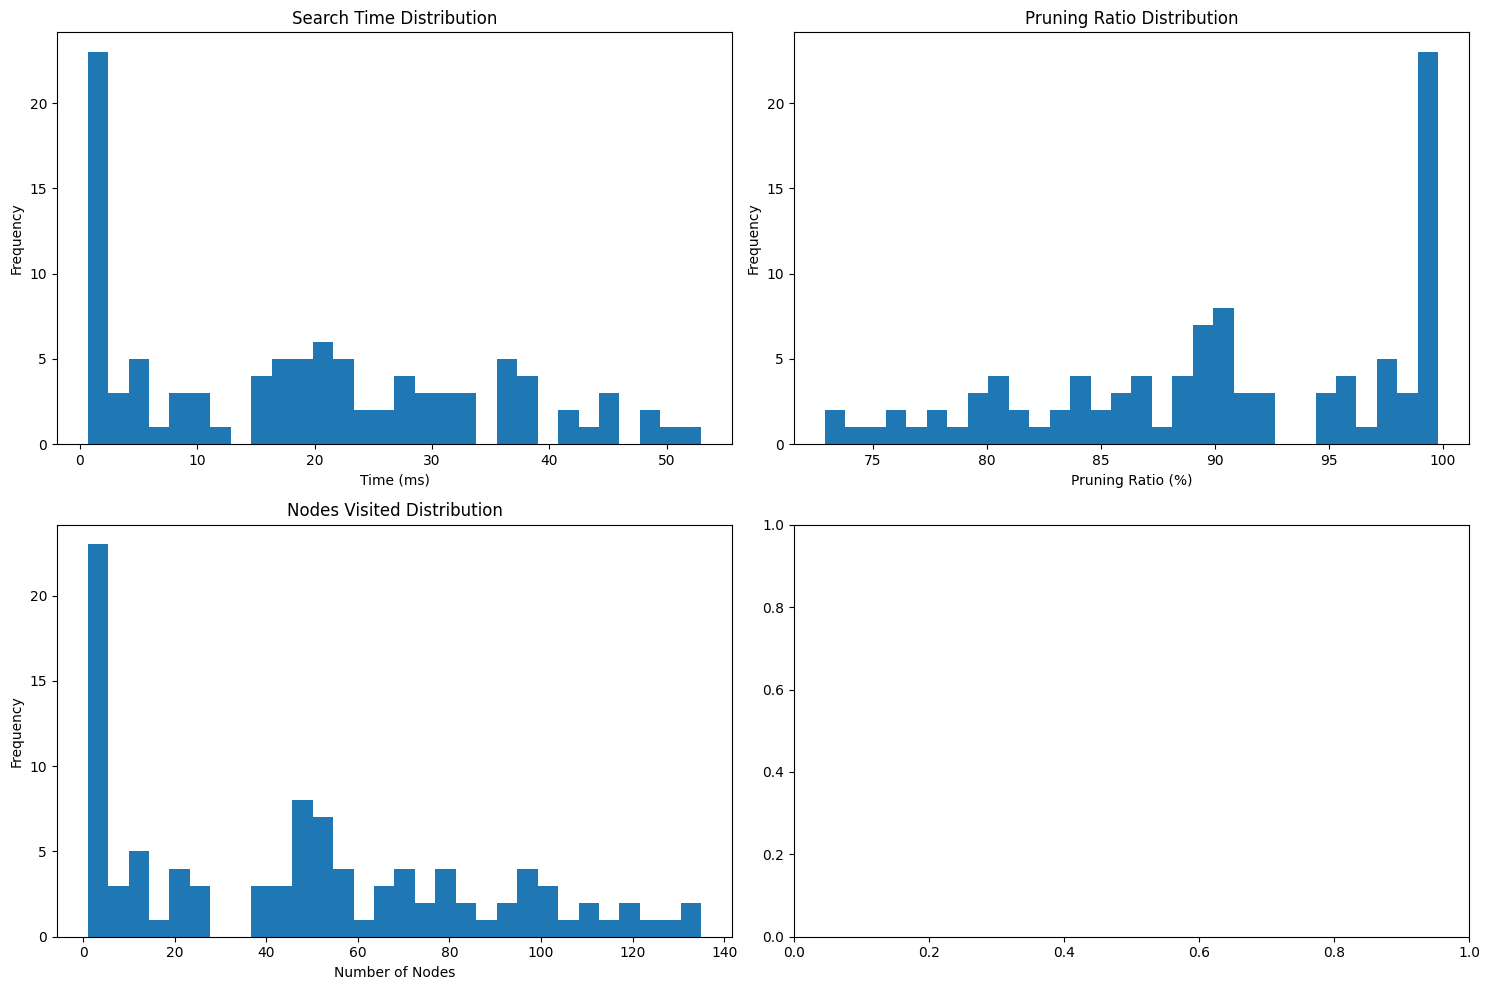


Running benchmark with 5000 points...
Generating 5000 test points...
Building R-tree...


100%|██████████| 5000/5000 [00:13<00:00, 384.08it/s]


Generating 100 query rectangles...
Running benchmark...


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]



Results for 5000 points:
Average search time: 114.70 ms
Average pruning ratio: 88.06%
Average nodes visited: 298.66
Average query rectangle size: 0.08


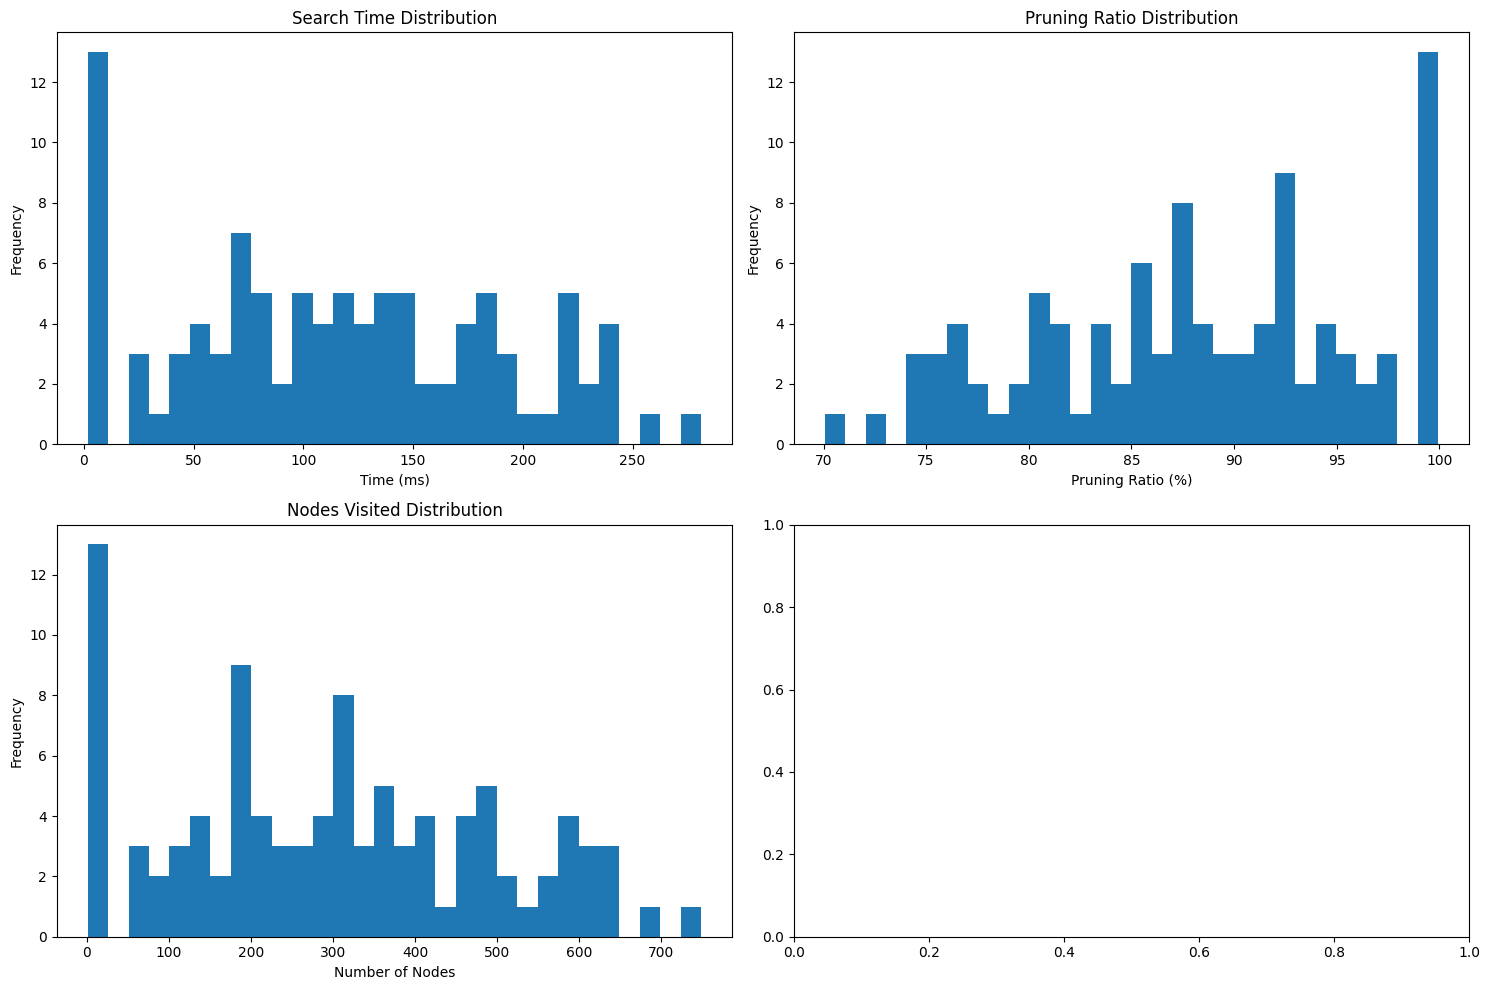


Running benchmark with 10000 points...
Generating 10000 test points...
Building R-tree...


100%|██████████| 10000/10000 [00:28<00:00, 355.54it/s]


Generating 100 query rectangles...
Running benchmark...


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]



Results for 10000 points:
Average search time: 262.30 ms
Average pruning ratio: 86.18%
Average nodes visited: 691.17
Average query rectangle size: 0.08


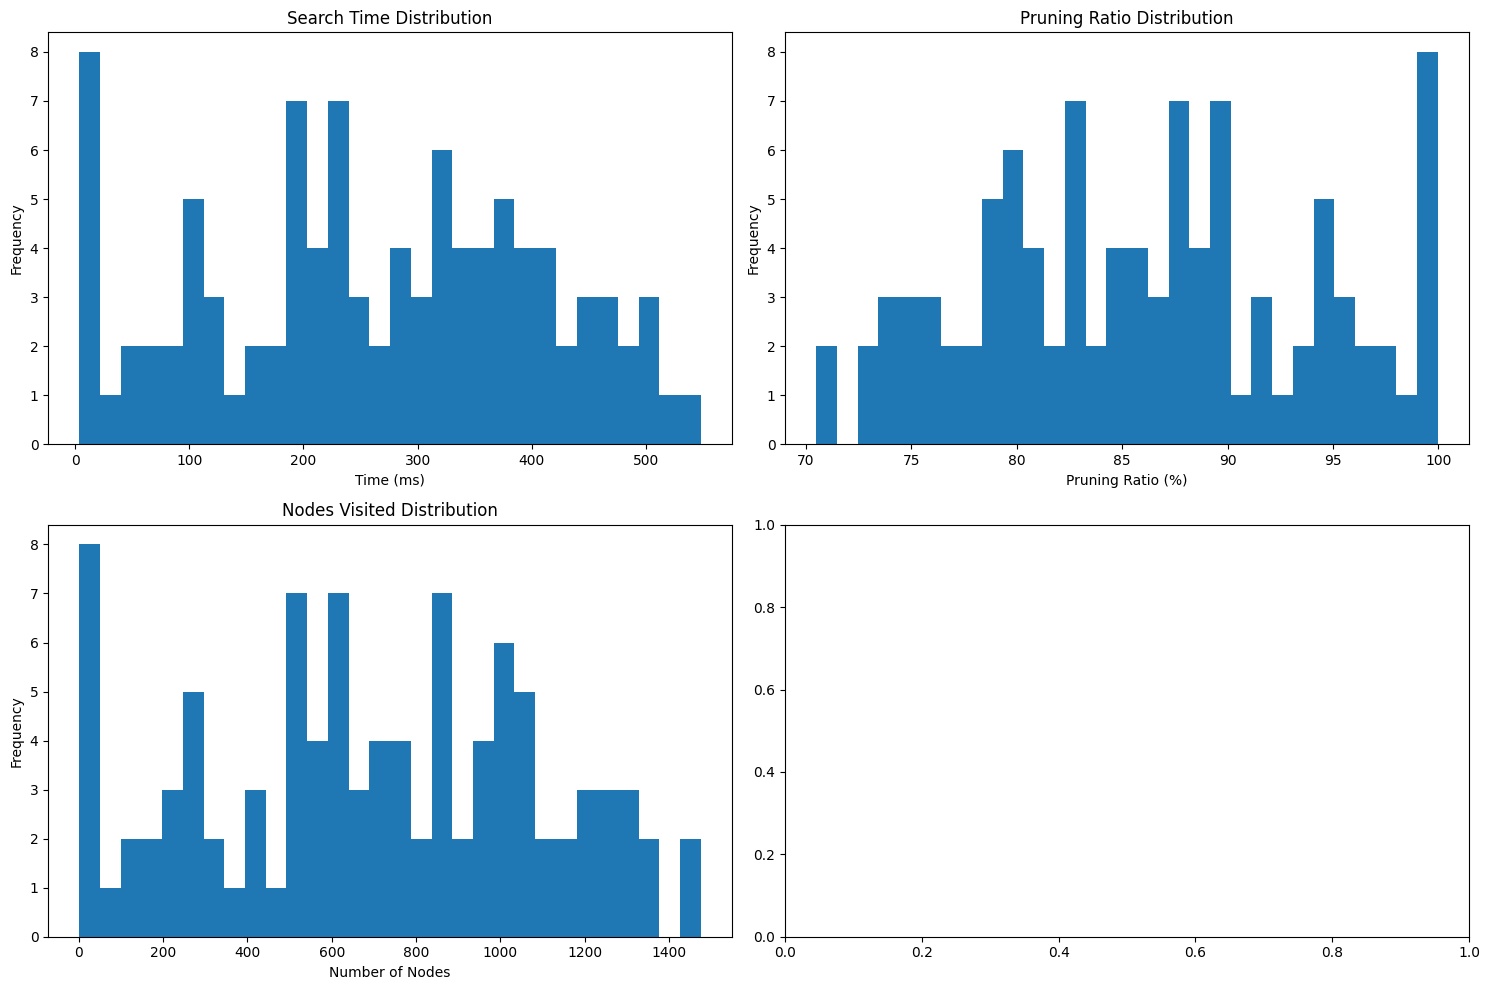

In [53]:
import numpy as np
import time

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random

def generate_test_data(n_points=1000, train_data=None):
    """Generate test points from training data"""
    if train_data is None or len(train_data) == 0:
        raise ValueError("train_data must be provided and non-empty")
    
    # If requested points is more than available data, return all data
    n_points = min(n_points, len(train_data))
    return train_data[:n_points]

def generate_query_rectangles(n_queries=100, train_data=None, min_points=2, max_points=5):
    """
    Generate query rectangles by selecting random points from training data
    and creating minimum bounding rectangles around them.
    
    Args:
        n_queries: Number of query rectangles to generate
        train_data: Training data points to sample from
        min_points: Minimum number of points to use for each rectangle
        max_points: Maximum number of points to use for each rectangle
    """
    if train_data is None or len(train_data) == 0:
        raise ValueError("train_data must be provided and non-empty")
    
    queries = []
    dimensions = len(train_data[0])  # Get dimensionality from data
    
    for _ in range(n_queries):
        # Randomly select number of points for this query
        n_points = random.randint(min_points, max_points)
        
        # Randomly sample points from training data
        sample_points = random.sample(list(train_data), n_points)
        
        # Convert points to numpy array for easier manipulation
        points_array = np.array(sample_points)
        
        # Get min and max coordinates across all dimensions
        mins = np.min(points_array, axis=0)
        maxs = np.max(points_array, axis=0)
        
        # Add small padding to ensure points are contained (optional)
        padding = 0.01 * (maxs - mins)  # 1% padding
        mins -= padding
        maxs += padding
        
        queries.append((tuple(mins), tuple(maxs)))
    
    return queries



def count_node_visits():
    """Decorator to count node visits during search"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            wrapper.visits = 0
            wrapper.total_nodes = 0
            
            def count_visit(node):
                wrapper.visits += 1
                
            # Monkey patch the _search_node method to count visits
            original_search = args[0]._search_node
            def new_search(node, search_rect, results):
                wrapper.total_nodes += 1
                count_visit(node)
                return original_search(node, search_rect, results)
            
            args[0]._search_node = new_search
            
            result = func(*args, **kwargs)
            
            # Restore original method
            args[0]._search_node = original_search
            
            return result, wrapper.visits, wrapper.total_nodes
        return wrapper
    return decorator

@count_node_visits()

def range_search_with_stats(rtree, search_rect):
    """Wrapped range search that tracks statistics"""
    
    return rtree.range_search(search_rect)



def plot_benchmark_results(results):
    """Plot benchmark results"""
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot search times
    times = [r['time'] * 1000 for r in results]  # Convert to milliseconds
    ax1.hist(times, bins=30)
    ax1.set_title('Search Time Distribution')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Frequency')
    
    # Plot pruning ratios
    pruning_ratios = [r['pruning_ratio'] * 100 for r in results]  # Convert to percentage
    ax2.hist(pruning_ratios, bins=30)
    ax2.set_title('Pruning Ratio Distribution')
    ax2.set_xlabel('Pruning Ratio (%)')
    ax2.set_ylabel('Frequency')
    
    # Plot nodes visited
    nodes_visited = [r['nodes_visited'] for r in results]
    ax3.hist(nodes_visited, bins=30)
    ax3.set_title('Nodes Visited Distribution')
    ax3.set_xlabel('Number of Nodes')
    ax3.set_ylabel('Frequency')
    
    
    plt.tight_layout()
    plt.show()

def run_benchmark(train_data, n_points=10000, n_queries=100):
    """
    Modified benchmark function to use training data
    """
    # Generate test data from training data
    print(f"Generating {n_points} test points...")
    points = generate_test_data(n_points, train_data)
    
    # Build R-tree
    print("Building R-tree...")
    rtree = RTree(max_entries=4, min_entries=2)
    for point in tqdm(points):
        point_as_rect = (point, point)  # Convert point to degenerate rectangle
        rtree.insert(point_as_rect, point)
    
    # Generate query rectangles from training data
    print(f"Generating {n_queries} query rectangles...")
    queries = generate_query_rectangles(n_queries, train_data)
    
    # Run benchmark
    print("Running benchmark...")
    results = []
    for query in tqdm(queries):
        start_time = time.time()
        search_rect = Rect(query[0], query[1])
        search_results, nodes_visited, total_nodes = range_search_with_stats(rtree, search_rect)
        total_nodes1, leaf_nodes, internal_nodes = rtree.count_total_nodes()
        end_time = time.time()
        
        results.append({
            'time': end_time - start_time,
            'nodes_visited': nodes_visited,
            'total_nodes': total_nodes1,
            'pruning_ratio': 1 - (nodes_visited / total_nodes1) if total_nodes > 0 else 0,
            'query_size': np.mean(np.array(query[1]) - np.array(query[0]))  # Average query rectangle size
        })
    
    return results

# Example usage:
if __name__ == "__main__":
    # Assuming train_data is your input data
    # train_data should be a list/array of points where each point is a tuple/array of coordinates
    
    np.random.seed(42)
    random.seed(42)
    
    # Run benchmark with different dataset sizes
    dataset_sizes = [1000, 5000, 10000]
    all_results = {}
    
    for size in dataset_sizes:
        print(f"\nRunning benchmark with {size} points...")
        results = run_benchmark(train_data, n_points=size, n_queries=100)
        all_results[size] = results
        
        # Calculate and print summary statistics
        avg_time = np.mean([r['time'] * 1000 for r in results])  # Convert to ms
        avg_pruning = np.mean([r['pruning_ratio'] * 100 for r in results])
        avg_nodes = np.mean([r['nodes_visited'] for r in results])
        avg_query_size = np.mean([r['query_size'] for r in results])
        
        print(f"\nResults for {size} points:")
        print(f"Average search time: {avg_time:.2f} ms")
        print(f"Average pruning ratio: {avg_pruning:.2f}%")
        print(f"Average nodes visited: {avg_nodes:.2f}")
        print(f"Average query rectangle size: {avg_query_size:.2f}")
        
        # Plot results for this dataset size
        plot_benchmark_results(results)